In [1]:
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3060 Laptop GPU


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image, ImageFile
import numpy as np

In [3]:
train_data_path = "/home/aimotion/Desktop/Radiate/AIAS/Face Mask Dataset/Train"
val_data_path = "/home/aimotion/Desktop/Radiate/AIAS/Face Mask Dataset/Validation"
test_data_path = "/home/aimotion/Desktop/Radiate/AIAS/Face Mask Dataset/Test"

In [4]:
transform_train= torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=[0.56850857, 0.46480802, 0.416202],
                    std=[0.23890273, 0.21876465, 0.21460944] )
])
train_data = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform_train)

In [5]:
transform_val = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64,64)),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=[0.5719676, 0.46902835, 0.4208306],
                    std=[0.23954803, 0.22196493, 0.21919987] )
])

val_data = torchvision.datasets.ImageFolder(root=val_data_path, transform=transform_val)

In [6]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64,64)),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=[0.5714287, 0.46706372, 0.41802087],
                    std=[0.23954803, 0.21817042, 0.21488766] )
])

test_data = torchvision.datasets.ImageFolder(root=test_data_path, transform=transform_val)

In [7]:
batch_size=128

In [8]:
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size) 
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size) 

In [9]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(val_data)}')
print(f'Number of test examples: {len(test_data)}')

Number of training examples: 10000
Number of validation examples: 800
Number of test examples: 992


In [10]:
class SimpleNet(nn.Module):

    def __init__(self):
        super(SimpleNet, self).__init__() # 1 input layer, 2 hidden layers, 1 ouput layer 
        self.fc1 = nn.Linear(12288, 84)   # Linear means fully connected layer. 12288 is the number of input from 64*64*3(RGB)  
        self.fc2 = nn.Linear(84, 50)
        self.fc3 = nn.Linear(50,2)   #2 is the number of ouput because we have two ouputs (With mask / Without mask)
    
    def forward(self, x):
        x = x.view(-1, 12288) # view() : Convert 3D tensor in to 1D tensor
        x = F.relu(self.fc1(x)) #For hidden layers, the ReLu function is common
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
simplenet = SimpleNet()

In [12]:
optimizer = optim.Adam(simplenet.parameters(), lr=0.001)
#Adam is used as an optimizer, which uses a learning rate per parameter, and adapts that learning rate depending on the rate of change of those parameters.
#lr is a learning rate

In [13]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

simplenet.to(device)

SimpleNet(
  (fc1): Linear(in_features=12288, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

In [14]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs, device):
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        num_correct_train = 0 #
        num_examples_train = 0 #
        for batch in train_loader:
            optimizer.zero_grad() #It is used to make sure the gradients are reset to zero after we’re done with the loop.
            inputs, targets = batch #About batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets) #Loss function
            loss.backward() #Back propagation
            optimizer.step() #Optimizer
            training_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets) #
            num_correct_train += torch.sum(correct).item() #
            num_examples_train += correct.shape[0] #
        training_loss /= len(train_loader.dataset)

        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets) #For the ouput layer : The softemax function and the sigmoid function are common
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)
        
        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, Training accuracy = {:.2f}, Validation accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct_train / num_examples_train ,num_correct / num_examples))

In [15]:
train(simplenet, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,val_data_loader, epochs=30, device=device)
#CrossEntropy is used as a loss function

Epoch: 1, Training Loss: 2.42, Validation Loss: 19.34, Training accuracy = 0.90, Validation accuracy = 0.50
Epoch: 2, Training Loss: 3.40, Validation Loss: 7.55, Training accuracy = 0.78, Validation accuracy = 0.52
Epoch: 3, Training Loss: 1.64, Validation Loss: 1.82, Training accuracy = 0.71, Validation accuracy = 0.56
Epoch: 4, Training Loss: 0.61, Validation Loss: 0.59, Training accuracy = 0.79, Validation accuracy = 0.73
Epoch: 5, Training Loss: 0.40, Validation Loss: 0.52, Training accuracy = 0.83, Validation accuracy = 0.82
Epoch: 6, Training Loss: 0.31, Validation Loss: 0.47, Training accuracy = 0.88, Validation accuracy = 0.83
Epoch: 7, Training Loss: 0.27, Validation Loss: 0.42, Training accuracy = 0.90, Validation accuracy = 0.85
Epoch: 8, Training Loss: 0.25, Validation Loss: 0.36, Training accuracy = 0.91, Validation accuracy = 0.87
Epoch: 9, Training Loss: 0.20, Validation Loss: 0.34, Training accuracy = 0.92, Validation accuracy = 0.90
Epoch: 10, Training Loss: 0.19, Vali

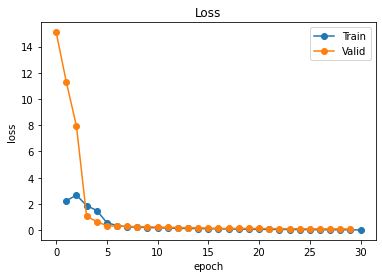

In [19]:
import matplotlib.pyplot as plt
import numpy as np

epoch = np.arange(1, 31, 1)

plt.plot(epoch, training_loss,'-o')
plt.plot(valid_loss,'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Loss')
 
plt.show()

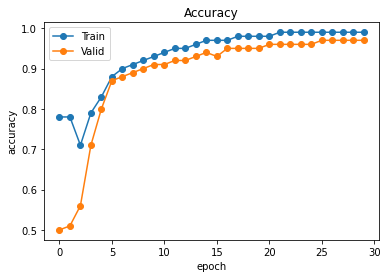

In [20]:
plt.plot(train_acc,'-o')
plt.plot(valid_acc,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Accuracy')
 
plt.show()

In [29]:
def test(model, test_loader, device):
    
    num_correct = 0 
    num_examples = 0
    batch = 992
    for batch in test_loader:
        inputs, targets = batch
        inputs = inputs.to(device)
        output = model(inputs)
        targets = targets.to(device)
        correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]
        
        print('Accuracy = {:.2f}'.format(num_correct / num_examples))

In [30]:
test(simplenet, test_data_loader, device=device)

Accuracy = 0.86
Accuracy = 0.92
Accuracy = 0.93
Accuracy = 0.93
Accuracy = 0.94
Accuracy = 0.95
Accuracy = 0.96
Accuracy = 0.96
